<a href="https://colab.research.google.com/github/pa8anas/fault-detection-of-household-appliances-from-electricity-consumption/blob/main/anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
#/content/drive/MyDrive/DRED.csv
from google.colab import drive
drive.mount('/content/drive')
path = "./content/drive/MyDrive/DRED.h5"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
!pip install -U https://github.com/nilmtk/nilmtk/archive/master.zip#egg=nilmtk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/nilmtk/nilmtk/archive/master.zip
  Preparing metadata (setup.py) ... done


In [5]:
!pip install -U https://github.com/nilmtk/nilm_metadata/archive/master.zip#egg=nilm_metadata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/nilmtk/nilm_metadata/archive/master.zip
  Preparing metadata (setup.py) ... done


In [40]:
import warnings; warnings.filterwarnings('ignore')

from nilmtk import DataSet
train = DataSet('/content/drive/MyDrive/Dataset Diplwmatikh/ukdale.h5')
#train = DataSet('/content/drive/MyDrive/DRED.h5')
train.set_window(end="05-1-2013") #Use data only until 5/1/2015
train_elec = train.buildings[1].elec

In [41]:
print(train_elec)

MeterGroup(meters=
  ElecMeter(instance=2, building=1, dataset='UK-DALE', appliances=[Appliance(type='boiler', instance=1)])
  ElecMeter(instance=3, building=1, dataset='UK-DALE', appliances=[Appliance(type='solar thermal pumping station', instance=1)])
  ElecMeter(instance=4, building=1, dataset='UK-DALE', appliances=[Appliance(type='laptop computer', instance=1), Appliance(type='laptop computer', instance=3)])
  ElecMeter(instance=5, building=1, dataset='UK-DALE', appliances=[Appliance(type='washer dryer', instance=1), Appliance(type='washer dryer', instance=2)])
  ElecMeter(instance=6, building=1, dataset='UK-DALE', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=7, building=1, dataset='UK-DALE', appliances=[Appliance(type='television', instance=1)])
  ElecMeter(instance=8, building=1, dataset='UK-DALE', appliances=[Appliance(type='light', instance=1), Appliance(type='light', instance=2)])
  ElecMeter(instance=9, building=1, dataset='UK-DALE', appliances

In [42]:
train_mains = train_elec.mains() # The aggregated meter that provides the input
#train_mains = train_elec.mains().power_series_all_data()
#train_mains = np.array(list(train_elec.mains().power_series_all_data()))

print(train_elec.mains().power_series_all_data().head())
#print(train_elec.submeters())
train_meter = train_elec.submeters()['microwave'] # The microwave meter that is used as a training target

2013-03-17 19:12:43.100000+00:00    337.880005
2013-03-17 19:12:44.100000+00:00    339.429993
2013-03-17 19:12:45.100000+00:00    340.630005
2013-03-17 19:12:46.100000+00:00    338.799988
2013-03-17 19:12:47.100000+00:00    340.880005
Name: (power, active), dtype: float32


In [43]:
def _normalize(chunk, mmax):
    '''Normalizes timeseries

    Parameters
    ----------
    chunk : the timeseries to normalize
    max : max value of the powerseries

    Returns: Normalized timeseries
    '''
    tchunk = chunk / mmax
    return tchunk

In [45]:
import numpy as np
def apply_on_chunk(mainchunk, meterchunk, epochs=5, batch_size=8, window_size=1):
    '''Train using only one chunk

    Parameters
    ----------
    mainchunk : chunk of site meter
    meterchunk : chunk of appliance
    epochs : number of epochs for training
    batch_size : size of batch used for training
    '''
    
    print("mainchunk  : ",np.shape(mainchunk))
    
    # Replace NaNs with 0s
    mainchunk.fillna(0, inplace=True)
    meterchunk.fillna(0, inplace=True)
    #ix = mainchunk.index.intersection(meterchunk.index)
    #mainchunk = np.array(mainchunk[ix])
    #meterchunk = np.array(meterchunk[ix])

    
    print("mainchunk  : ",np.shape(mainchunk))
    
    
    indexer = np.arange(window_size)[None, :] + np.arange(len(mainchunk)-window_size+1)[:, None]
    mainchunk = mainchunk[indexer]
    meterchunk = meterchunk[window_size-1:]
    mainchunk = np.reshape(mainchunk, (mainchunk.shape[0], mainchunk.shape[1],1))

    #self.model.fit(mainchunk, meterchunk, epochs=epochs, batch_size=batch_size, shuffle=True)
    return mainchunk, meterchunk




def convert_time(timestamp):
    return pd.to_datetime(timestamp, unit='ms')

def get_second(date):
    return date.second

def get_minute(date):
    return date.minute

def get_hour(date):
    return date.hour

def get_day(date):
    return date.day

def get_month(date):
    return date.month

def get_year(date):
    return date.year

In [46]:
main_power_series  = train_mains.power_series()
meter_power_series = train_meter.power_series()
mmax = 1


    
# Train chunks
run = True
mainchunk = next(main_power_series)
meterchunk = next(meter_power_series)
if mmax == None:
    mmax = mainchunk.max()

while(run):
    
    mainchunk = _normalize(mainchunk, mmax)
    meterchunk = _normalize(meterchunk, mmax)

    #self.train_on_chunk(mainchunk, meterchunk, epochs, batch_size)
    try:
        mainchunk = next(main_power_series)
        meterchunk = next(meter_power_series)
        print("1")
        mainchunks, meterchunks = apply_on_chunk(mainchunk, meterchunk, epochs, batch_size)
    except Exception as e:
        print(e)
        run = False

In [47]:
mainchunks, meterchunks = apply_on_chunk(mainchunk, meterchunk)

print("mainchunks  : ",np.shape(mainchunks))

print("meterchunks : ",np.shape(meterchunks))

mainchunk  :  (3633254,)
mainchunk  :  (3633254,)
mainchunks  :  (3633254, 1, 1)
meterchunks :  (1508581,)


In [48]:
df_main  = mainchunk.to_frame()  
df_meter = meterchunk.to_frame()

df_main['power appliance'] = df_meter

df_main.columns =['power apparent','power appliance']

df_meter = df_main['power appliance']



df_main["power appliance"].fillna("0", inplace = True)
df_main = df_main.reset_index()

df_main.columns =['date','power apparent','power appliance']


df_main['second']   = df_main['date'].apply(get_second)
df_main['minute']   = df_main['date'].apply(get_minute)
df_main['hour']   = df_main['date'].apply(get_hour)
df_main['day']    = df_main['date'].apply(get_day)
df_main['month']  = df_main['date'].apply(get_month)
df_main['year']   = df_main['date'].apply(get_year)

In [49]:
print(df_main)

                                    date  power apparent power appliance  \
0       2013-03-17 19:12:43.100000+00:00      337.880005               0   
1       2013-03-17 19:12:44.100000+00:00      339.429993               0   
2       2013-03-17 19:12:45.100000+00:00      340.630005               0   
3       2013-03-17 19:12:46.100000+00:00      338.799988               0   
4       2013-03-17 19:12:47.100000+00:00      340.880005               0   
...                                  ...             ...             ...   
3633249 2013-04-30 23:59:55.800000+01:00      205.539993               0   
3633250 2013-04-30 23:59:56.800000+01:00      205.679993               0   
3633251 2013-04-30 23:59:57.800000+01:00      206.070007               0   
3633252 2013-04-30 23:59:58.800000+01:00      205.669998               0   
3633253 2013-04-30 23:59:59.800000+01:00      205.860001               0   

         second  minute  hour  day  month  year  
0            43      12    19   17   

In [50]:
df = df_main['date'].to_frame()
df['year'] = df_main['year']
df['month'] = df_main['month']
df['day'] = df_main['day']
df['hour'] = df_main['hour']
df['minute'] = df_main['minute']
df['second'] = df_main['second']
df['power apparent'] = df_main['power apparent']
df['power appliance'] = df_main['power appliance']

In [51]:
df.head(10)

,date,year,month,day,hour,minute,second,power apparent,power appliance
0,2013-03-17 19:12:43.100000+00:00,2013,3,17,19,12,43,337.880005,0
1,2013-03-17 19:12:44.100000+00:00,2013,3,17,19,12,44,339.429993,0
2,2013-03-17 19:12:45.100000+00:00,2013,3,17,19,12,45,340.630005,0
3,2013-03-17 19:12:46.100000+00:00,2013,3,17,19,12,46,338.799988,0
4,2013-03-17 19:12:47.100000+00:00,2013,3,17,19,12,47,340.880005,0
5,2013-03-17 19:12:48.100000+00:00,2013,3,17,19,12,48,338.769989,0
6,2013-03-17 19:12:49.200000+00:00,2013,3,17,19,12,49,340.190002,0
7,2013-03-17 19:12:50.100000+00:00,2013,3,17,19,12,50,340.209991,0
8,2013-03-17 19:12:51.200000+00:00,2013,3,17,19,12,51,338.489990,0
9,2013-03-17 19:12:52.100000+00:00,2013,3,17,19,12,52,341.329987,0


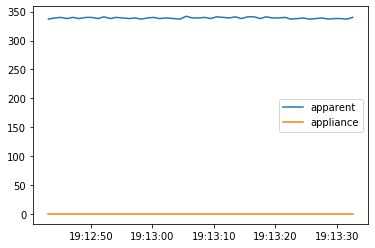

In [52]:
appliance = df['power appliance'][:50].astype(int)
apparent = df['power apparent'][:50].astype(int)
time = df['date'][:50]

fig, ax = plt.subplots()
ax.plot(time, apparent, label="apparent")
ax.plot(time, appliance, label="appliance")
ax.legend()

plt.show()

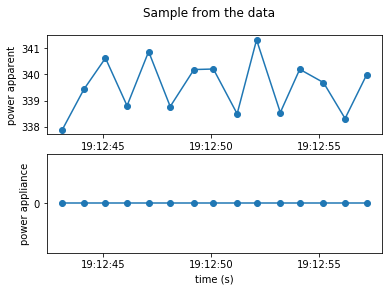

In [53]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('Sample from the data')

ax1.plot(df['date'][:15], df['power apparent'][:15], 'o-')
ax1.set_ylabel('power apparent')

ax2.plot(df['date'][:15], df['power appliance'][:15].astype(str), 'o-')
ax2.set_xlabel('time (s)')
ax2.set_ylabel('power appliance')

plt.show()

In [54]:
def min_to_sec_data(value1, value2):
    
    diff = (value2-value1)/60
    val = value1
    points = [value1]
    
    for i in range(60):
        val += diff#(diff/60)*i
        points.append(val)
    return points


In [55]:
mainchunk.values
uppsampled_mainchunks = []

for i in range(0,len(mainchunk.values)-1,2):
    uppsampled_mainchunks.append(min_to_sec_data(mainchunk.values[i],mainchunk.values[i+1]))

In [56]:
uppsampled_mainchunks = np.array(uppsampled_mainchunks)

In [57]:
uppsampled_mainchunks = np.reshape(uppsampled_mainchunks, (uppsampled_mainchunks.shape[0]*uppsampled_mainchunks.shape[1],1))
uppsampled_mainchunks

array([[337.88000488],
       [337.90583801],
       [337.93167114],
       ...,
       [205.8536672 ],
       [205.8568339 ],
       [205.86000061]])

In [58]:
print(uppsampled_mainchunks.shape)

(110814247, 1)


In [59]:
import numpy as np
from numpy.lib.stride_tricks import as_strided

def local_mean_range(P):
    d = np.array(P)

    consec = 3
    offset = 0
    nsub = 1
    pace = 1

    s = d.strides[0]
    ngroups= (d.shape[0] - (consec + (nsub-1)*offset - 1))//pace
    a = as_strided(d, shape=(ngroups, nsub, consec),
                   strides=(pace*s, offset*s, 1*s))

    local_mean = a.mean(axis=-1).mean(axis=-1)
    return local_mean[0]

def deviation_range(P):
    return np.std(P)

mean = local_mean_range(P=[10,5,5])
dev  = deviation_range(P=[10,5,5])

def event_detected(P):
    detected = True
    
    return detected

print("Computing for [10,5,5]\n")
print('local mean\t   deviation\t\tvariance\t\taverage')
print(mean, dev, np.var([10,5,5]), np.average([10,5,5]))

Computing for [10,5,5]

local mean	   deviation		variance		average
6.666666666666667 2.357022603955158 5.5555555555555545 6.666666666666667


In [60]:
def three_point_method(P, P_s=[]):
    """
    three point method which will be applied on the dataset alongside the reconstruct_P
    """
    P_bar  =  np.average(P)
    teta_p =  deviation_range(P)
    teta_g = deviation_range(P)
    
    try:
        ps_previous = P_s[-1]
    except:
        ps_previous = 0
    
    if teta_p > teta_g:
        P_s.append(ps_previous)
    else:
        P_s.append(P_bar)
        
    return P_s

def reconstruct_P(P, P_s=[0,0], T_q=[0,0],t='',P_events=[], N_events=[]):
    """
    P is our three points which are needed to calculate the deviation
    P_s is the cleaned new signal
    T_q is the new array that will contain the q events
    t is the time at which the event started
    """
    Event_Detected = False
    
    teta_g = deviation_range(P)
    try:
        delta_Ps = P_s[-1] - P_s[-2]
    except:
        if P_s[-1]:
            delta_Ps = P_s[-1]
        else:
            delta_Ps =0
    
    if delta_Ps>=teta_g:
        T_q.append(t)
        Event_Detected = True
        
        
    P_events.append(0)
    N_events.append(0)
    
    if delta_Ps>0:
        P_events[-1] = P_s[-1]
    elif delta_Ps<0:
        N_events[-1] = P_s[-1]
        
    return T_q, P_events, N_events

In [61]:
from tqdm import tqdm
T_q = [df['date'][0]]
P_events, N_events = [],[]
P_s = []

for i in tqdm(range(0, len(df['power appliance']))):
    
    P = df['power appliance'][i:i+3].astype(float).values
    
    # Applying the three points method
    P_s = three_point_method(P, P_s)
    
    # Getting the event data
    T_q, P_events, N_events = reconstruct_P(P, P_s, T_q=T_q,t=df['date'][i],P_events=P_events, N_events=N_events)
    

100%|██████████| 3633254/3633254 [21:25<00:00, 2827.21it/s]


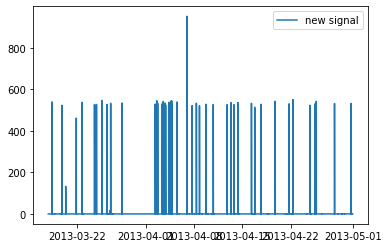

In [62]:
appliance = P_s
time = df['date'][:50]

fig, ax = plt.subplots()
ax.plot(df['date'], P_s, label="new signal")
ax.legend()

plt.show()

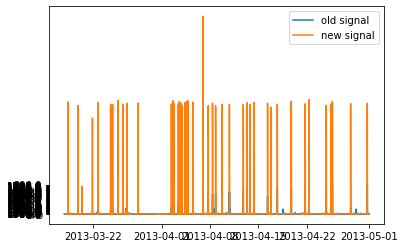

In [63]:
appliance = P_s
time = df['date'][:50]

fig, ax = plt.subplots()

ax.plot(df['date'], df['power appliance'].astype(str), label="old signal")

ax.plot(df['date'], P_s, label="new signal")

ax.legend()

plt.show()

[0. 0. 0. ... 0. 0. 0.]


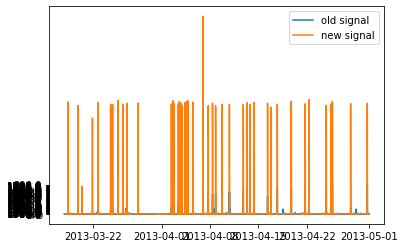

In [64]:
appliance = P_s
time = df['date'][:50]

P_string = np.array(P_s)#.dtype(np.int32)      # 32-bit integer
print(P_string)
fig, ax = plt.subplots()

ax.plot(df['date'], df['power appliance'].astype(str), label="old signal")
#ax.plot(df['date'][0:15], P_string[0:15], label="new signal")
ax.plot(df['date'], P_s, label="new signal")


ax.legend()

plt.show()

In [65]:
print(np.shape(P_s))
print(np.shape(T_q))

(3633254,)
(3425063,)


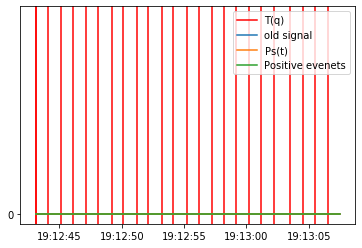

In [66]:
appliance = P_s
time = df['date'][:50]

#df_temp = pd.DataFrame(np.array(T_q[:50]), columns=list('abc'))
# pd.to_datetime(T_q[:50].datetime)

fig, ax = plt.subplots()

plt.axvline(T_q[0], color='red', label="T(q)")

for i in range(1,25):
    plt.axvline(T_q[i], color='red')
    
ax.plot(df['date'][:25], df['power appliance'][:25].astype(str), label="old signal")

ax.plot(df['date'][:25], P_s[:25], label="Ps(t)")
ax.plot(df['date'][:25], P_events[:25], label="Positive evenets")





    
ax.legend()

plt.show()

In [67]:
df['new signal'] = np.array(P_s)#.to_frame()  P_events  positive events

In [68]:
df.head(10)

,date,year,month,day,hour,minute,second,power apparent,power appliance,new signal
0,2013-03-17 19:12:43.100000+00:00,2013,3,17,19,12,43,337.880005,0,0.0
1,2013-03-17 19:12:44.100000+00:00,2013,3,17,19,12,44,339.429993,0,0.0
2,2013-03-17 19:12:45.100000+00:00,2013,3,17,19,12,45,340.630005,0,0.0
3,2013-03-17 19:12:46.100000+00:00,2013,3,17,19,12,46,338.799988,0,0.0
4,2013-03-17 19:12:47.100000+00:00,2013,3,17,19,12,47,340.880005,0,0.0
5,2013-03-17 19:12:48.100000+00:00,2013,3,17,19,12,48,338.769989,0,0.0
6,2013-03-17 19:12:49.200000+00:00,2013,3,17,19,12,49,340.190002,0,0.0
7,2013-03-17 19:12:50.100000+00:00,2013,3,17,19,12,50,340.209991,0,0.0
8,2013-03-17 19:12:51.200000+00:00,2013,3,17,19,12,51,338.489990,0,0.0
9,2013-03-17 19:12:52.100000+00:00,2013,3,17,19,12,52,341.329987,0,0.0


In [69]:
df_clust = df['new signal'].to_frame()
df_clust['power apparent'] = df['power apparent'] 

X = df_clust.values
X

array([[  0.        , 337.88000488],
       [  0.        , 339.42999268],
       [  0.        , 340.63000488],
       ...,
       [  0.        , 206.07000732],
       [  0.        , 205.66999817],
       [  0.        , 205.86000061]])

In [70]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

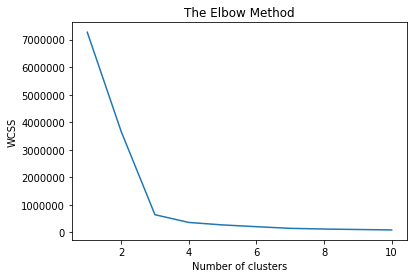

In [71]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [72]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

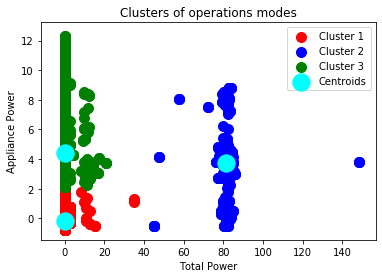

In [73]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'cyan', label = 'Centroids')
plt.title('Clusters of operations modes')
plt.xlabel('Total Power')
plt.ylabel('Appliance Power')
plt.legend()
plt.show()

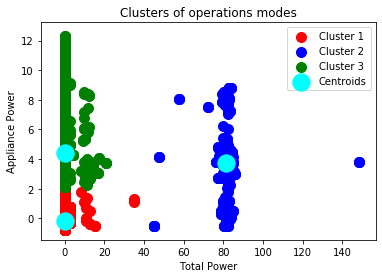

In [74]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'cyan', label = 'Centroids')
plt.title('Clusters of operations modes')
plt.xlabel('Total Power')
plt.ylabel('Appliance Power')
plt.legend()
plt.show()